## Modelado predictivo de demanda
Utilizaremos modelos de series temporales avanzados como Prophet y metodos de Machine Learning como arboles de decision para predecir la demanda futura basada en las características temporales y los clusters identificados.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Linear Regression
from sklearn.linear_model import LinearRegression

import lightgbm as lgb


### Predicción de demanda semanal por región

In [19]:
# Carga de datos
df = pd.read_csv('../data_clean/data_fe.csv', parse_dates=['Fecha'])
df['Cantidad_Semanal'] = df.groupby(['Region', 'semana'])['Cantidad'].transform('sum')
df[['ID_Venta', 'Fecha', 'Region', 'Cantidad_Semanal']].head(10)

,ID_Venta,Fecha,Region,Cantidad_Semanal
0,1449,2024-02-05,Buenos Aires,43
1,2043,2024-02-08,Buenos Aires,43
2,1680,2024-02-11,Buenos Aires,43
3,1754,2024-02-11,Buenos Aires,43
4,2703,2024-02-11,Buenos Aires,43
5,681,2024-02-13,Buenos Aires,66
6,223,2024-02-18,Buenos Aires,66
7,1983,2024-02-18,Buenos Aires,66
8,53,2024-02-19,Buenos Aires,40
9,447,2024-02-19,Buenos Aires,40


In [20]:
df_numeric = df.select_dtypes(include=np.number)
df_numeric.Cantidad_Semanal.describe()

count    2139.000000
mean       37.639551
std        19.070387
min         1.000000
25%        24.000000
50%        34.000000
75%        49.000000
max       100.000000
Name: Cantidad_Semanal, dtype: float64

In [21]:
X = df_numeric.drop(columns=['Cantidad', 'Cantidad_Semanal', 'Monto_Venta'])
y = df_numeric['Cantidad_Semanal']

# Train-test split (5-fold time series)
tscv = TimeSeriesSplit(n_splits=5)

### Baseline: Media móvil simple

In [22]:
# Baseline: Media movil simple
# Las ventas semanales en la region seran el promeido de las n semanas anteriores

n=2

# Empezamos en la semana n por region
idx = df[df['semana'] == n].index

# Calculamos la media movil para cada region
df['Pred_MA'] = df.groupby('Region')['Cantidad_Semanal'].transform(lambda x: x.shift(1).rolling(window=n, min_periods=1).mean())

# Evaluación del modelo de media movil
rmse_list = []
mae_list = []
max_errs_list = []

y_true_list = []
y_pred_list = []

for fi, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    y_true = df.loc[test_idx, 'Cantidad_Semanal']
    y_pred = df.loc[test_idx, 'Pred_MA']

    y_true_list.append(y_true)
    y_pred_list.append(y_pred)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    

    rmse_list.append(rmse)
    mae = mean_absolute_error(y_true, y_pred)
    mae_list.append(mae)
    max_err = np.max(np.abs(y_true - y_pred))
    max_errs_list.append(max_err)

    print(f"Fold {fi} - RMSE: {rmse}, MAE {mae}, Max Error: {max_err}")


Fold 1 - RMSE: 12.274739979854306, MAE 8.063202247191011, Max Error: 50.0
Fold 2 - RMSE: 12.797553970991856, MAE 8.36938202247191, Max Error: 53.0
Fold 3 - RMSE: 11.884716604279841, MAE 7.683988764044944, Max Error: 53.0
Fold 4 - RMSE: 12.638224523291377, MAE 8.47191011235955, Max Error: 50.0
Fold 5 - RMSE: 12.227593587612414, MAE 8.047752808988765, Max Error: 55.0



RMSE Promedio Media Movil: 12.364565733205959
MAE Promedio Media Movil: 8.127247191011236
Top 3 errores: [55.0, 53.0, 53.0]


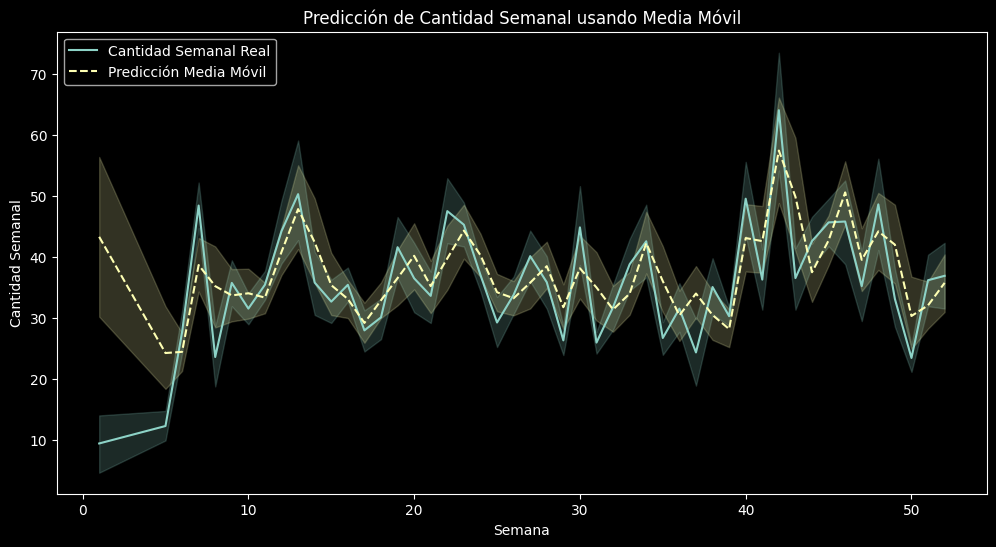

In [23]:
# Evaluación del baseline
avg_rmse_ma = np.mean(rmse_list)
print(f"\nRMSE Promedio Media Movil: {avg_rmse_ma}")

avg_mae_ma = np.mean(mae_list)
print(f"MAE Promedio Media Movil: {avg_mae_ma}")

top_3_errs_ma = sorted([float(x) for x in max_errs_list], reverse=True)[:3]
print("Top 3 errores:", top_3_errs_ma)


baseline_results_df = pd.DataFrame({
    'Model': ['Baseline_MA'],
    'RMSE': [avg_rmse_ma],
    'MAE': [avg_mae_ma],
    'Max_error': [top_3_errs_ma[0]]
})


# Visualización de resultados
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='semana', y='Cantidad_Semanal', errorbar=("ci", 95), label='Cantidad Semanal Real')
sns.lineplot(data=df, x='semana', y='Pred_MA', errorbar=("ci", 95), label='Predicción Media Móvil', linestyle='--')
plt.title('Predicción de Cantidad Semanal usando Media Móvil')
plt.xlabel('Semana')
plt.ylabel('Cantidad Semanal')
plt.legend()
plt.show()

### Manejo de NaNs

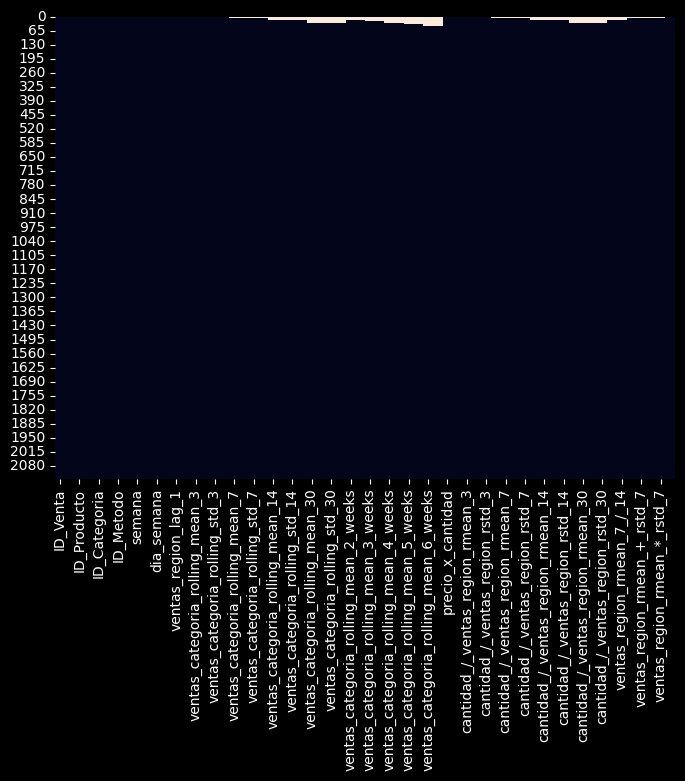

In [24]:
# Maejo de NaNs para modelos no capaces de manejarlos

X = X.ffill()

plt.figure(figsize=(8,6))
sns.heatmap(X.isna(), cbar=False)
plt.show()
plt.close()

# Solo nos quedamos con las filas sin NaNs para modelos no capaces de manejarlos
X_no_na = X.dropna()
y_no_na = y.loc[X_no_na.index]


## Modelo de Lasso

In [ ]:
from sklearn.linear_model import Lasso

# Modelo de Lasso
results = []

df['Pred_Lasso'] = np.nan

for train_index, test_index in tscv.split(X_no_na):
    X_train, X_test = X_no_na.iloc[train_index], X_no_na.iloc[test_index]
    y_train, y_test = y_no_na.iloc[train_index], y_no_na.iloc[test_index]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Entrenamiento del modelo
    lr_model = Lasso()
    lr_model.fit(X_train_scaled, y_train)

    # Predicciones
    y_pred_lr = lr_model.predict(X_test_scaled)
    
    # Guardar predicciones en el dataframe
    df.loc[X_no_na.index[test_index], 'Pred_Lasso'] = y_pred_lr

    # Evaluacion
    rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
    mae_lr = mean_absolute_error(y_test, y_pred_lr)
    max_err_lr = np.max(np.abs(y_test - y_pred_lr))

    results.append({
        'Model': 'Lasso',
        'RMSE': rmse_lr,
        'R2': lr_model.score(X_test_scaled, y_test),
        'MAE': mae_lr,
        'Max_error': max_err_lr
    })

# Mostrar coeficientes de Lasso
coef = pd.Series(lr_model.coef_, index=X_no_na.columns)
print("Coeficientes Lasso (no nulos):")
print(coef[coef != 0].sort_values(ascending=False).round(2))

lasso_results_df = pd.DataFrame(results)
print("\nResultados por fold:")
print(lasso_results_df)

print(f"\nMean RMSE: {lasso_results_df.RMSE.mean():.4f}")
print(f"Mean MAE: {lasso_results_df.MAE.mean():.4f}")
print(f"Mean R2: {lasso_results_df.R2.mean():.4f}")
print(f"Mean Max_error: {lasso_results_df.Max_error.mean():.4f}")

Coeficientes Lasso (no nulos):
ventas_categoria_rolling_mean_6_weeks    0.94
ventas_categoria_rolling_std_14          0.40
semana                                   0.39
ventas_categoria_rolling_mean_5_weeks    0.19
ID_Venta                                -0.23
ID_Cliente                              -0.35
ID_Region                               -8.49
dtype: float64

Resultados por fold:
   Model       RMSE        R2        MAE  Max_error
0  Lasso  16.395859  0.196693  13.001341  51.385811
1  Lasso  17.463710  0.122347  14.199310  52.867836
2  Lasso  16.825568  0.157780  13.214856  54.857537
3  Lasso  16.572335  0.271548  12.983121  54.611317
4  Lasso  15.716633  0.214491  11.899466  53.450376

Mean RMSE: 16.5948
Mean MAE: 13.0596
Mean R2: 0.1926
Mean Max_error: 53.4346


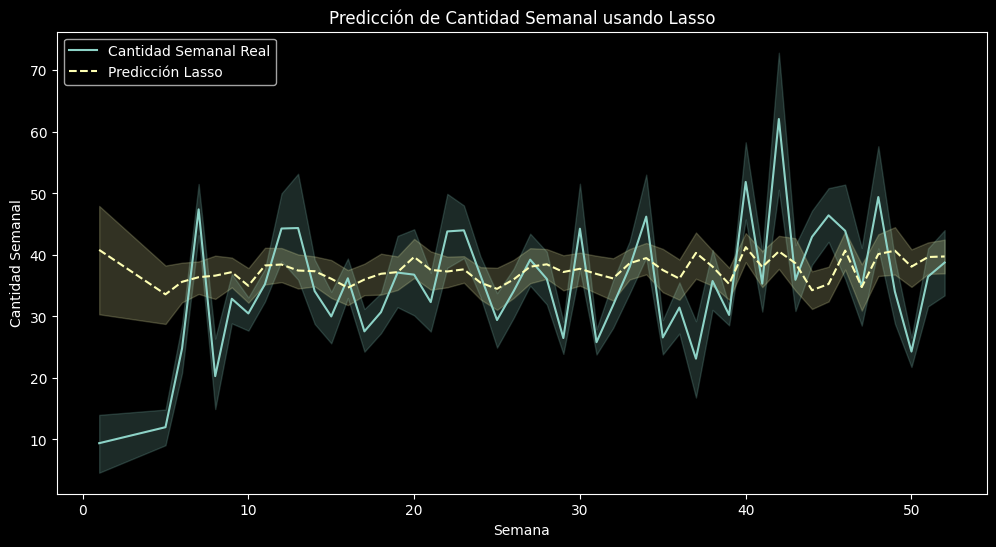

In [26]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df.dropna(subset=['Pred_Lasso']), x='semana', y='Cantidad_Semanal', errorbar=("ci", 95), label='Cantidad Semanal Real')
sns.lineplot(data=df.dropna(subset=['Pred_Lasso']), x='semana', y='Pred_Lasso', errorbar=("ci", 95), label='Predicción Lasso', linestyle='--')
plt.title('Predicción de Cantidad Semanal usando Lasso')
plt.xlabel('Semana')
plt.ylabel('Cantidad Semanal')
plt.legend()
plt.show()

### Modelo LGBM

In [ ]:
# Modelo LGBM
results = []

y_pred_lgbm = []
y_true_lgbm = []

df['Pred_LGBM'] = np.nan

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    # LightGBM dataset
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    # LightGBM parameters
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbose': -1
    }

    # Train the model
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=100,
                    valid_sets=lgb_eval
                    )
    
    # Predict
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    
    # Guardar predicciones en el dataframe
    df.loc[X.index[test_index], 'Pred_LGBM'] = y_pred

    y_pred_lgbm.extend(y_pred)
    y_true_lgbm.extend(y_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    max_err = np.max(np.abs(y_test - y_pred))

    results.append({
        'Model': 'LightGBM',
        'RMSE': rmse,
        'MAE': mae,
        'Max_error': max_err
    })

errors_lgbm = pd.DataFrame({
    'y_true': y_true_lgbm,
    'y_pred': y_pred_lgbm
})

lgbm_results_df = pd.DataFrame(results)
print("Resultados por fold:")
print(lgbm_results_df)
print()
print(f"Mean RMSE: {lgbm_results_df.RMSE.mean():.4f}")
print(f"Mean MAE: {lgbm_results_df.MAE.mean():.4f}")
print(f"Max error promedio: {lgbm_results_df['Max_error'].mean():.4f}")

Resultados por fold:
      Model       RMSE        MAE  Max_error
0  LightGBM  13.850517  10.874715  45.315103
1  LightGBM  13.058118  10.408797  38.215331
2  LightGBM  11.163610   8.914261  29.539388
3  LightGBM  10.638070   7.958594  33.583198
4  LightGBM   8.530002   6.644067  37.284216

Mean RMSE: 11.4481
Mean MAE: 8.9601
Max error promedio: 36.7874


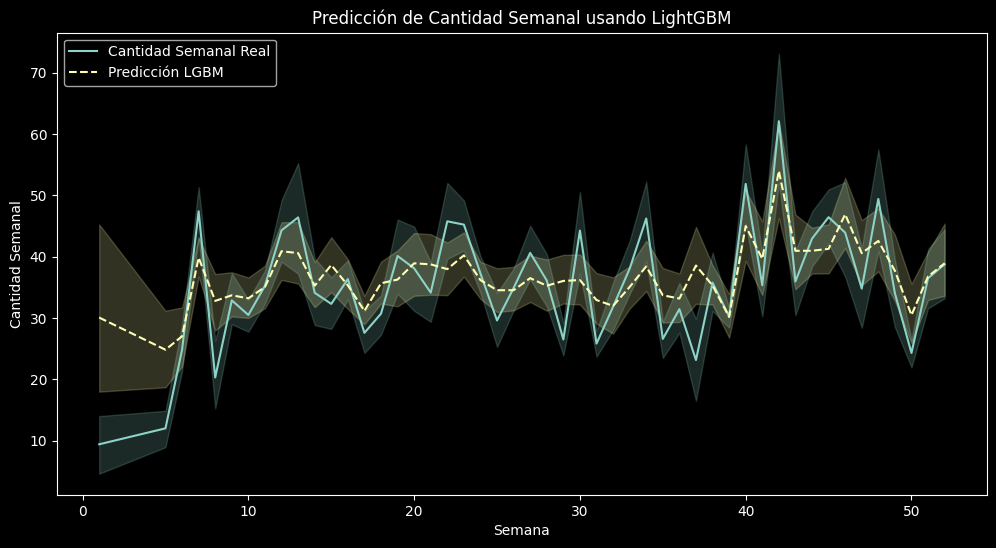

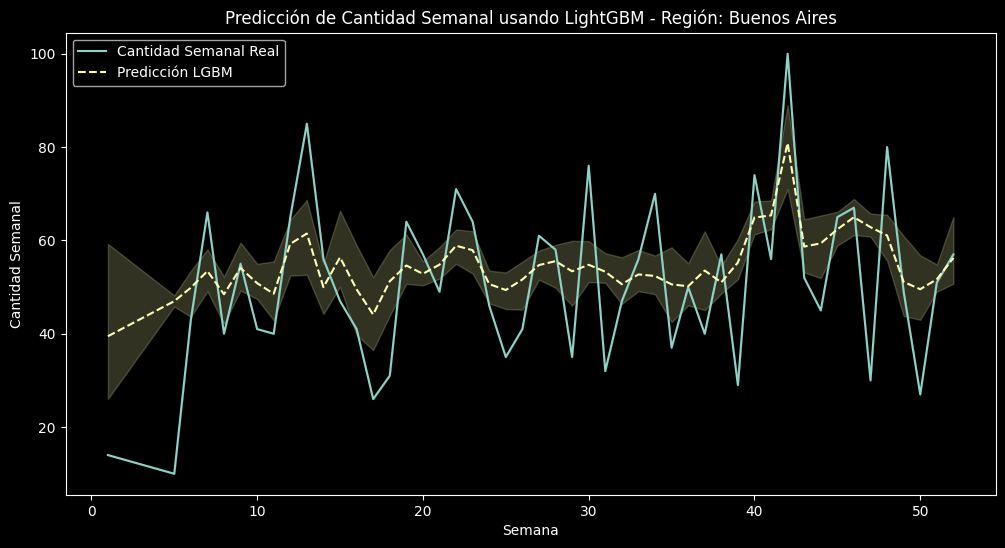

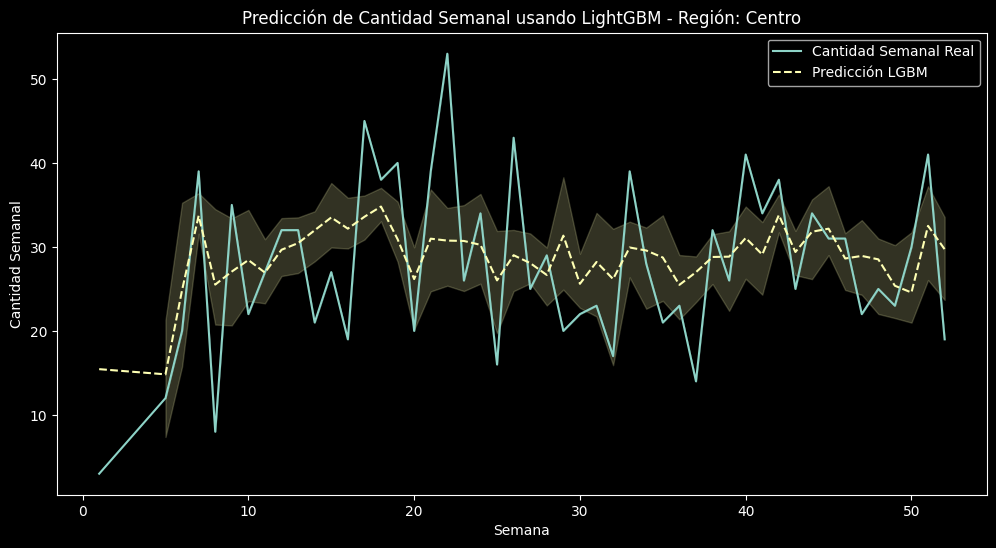

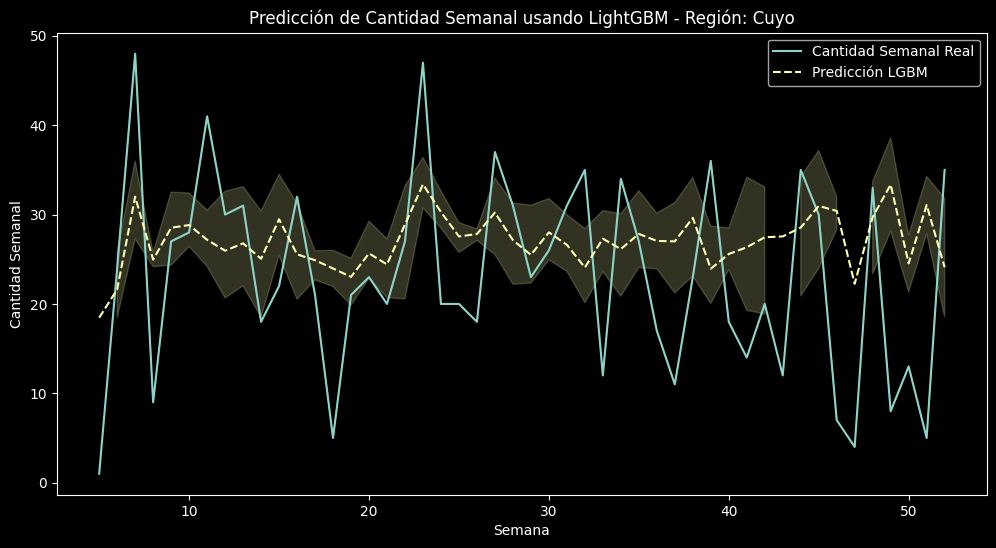

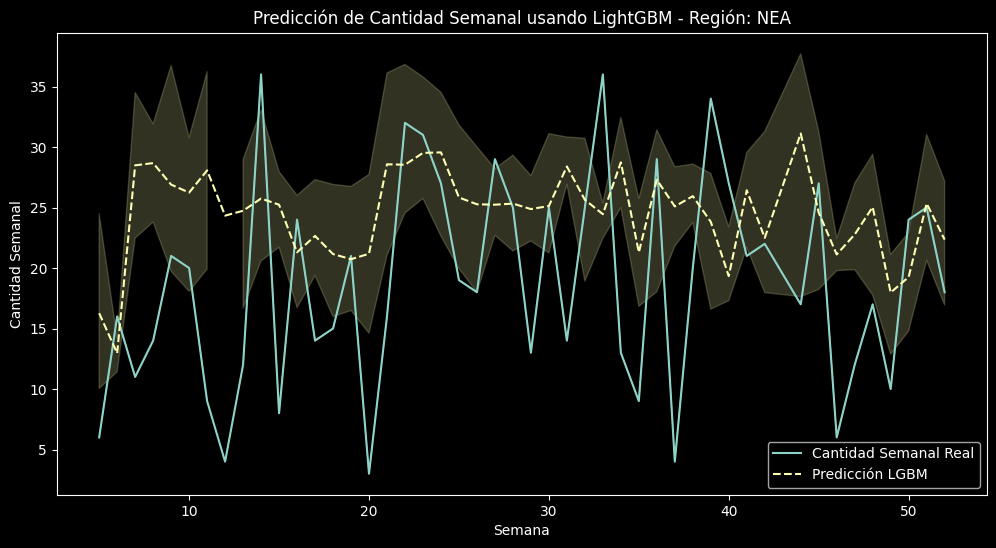

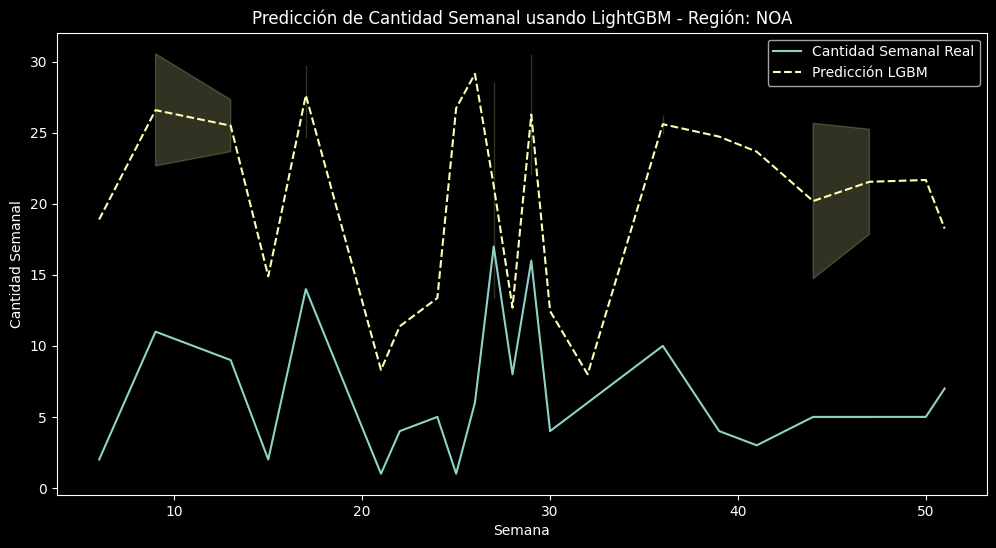

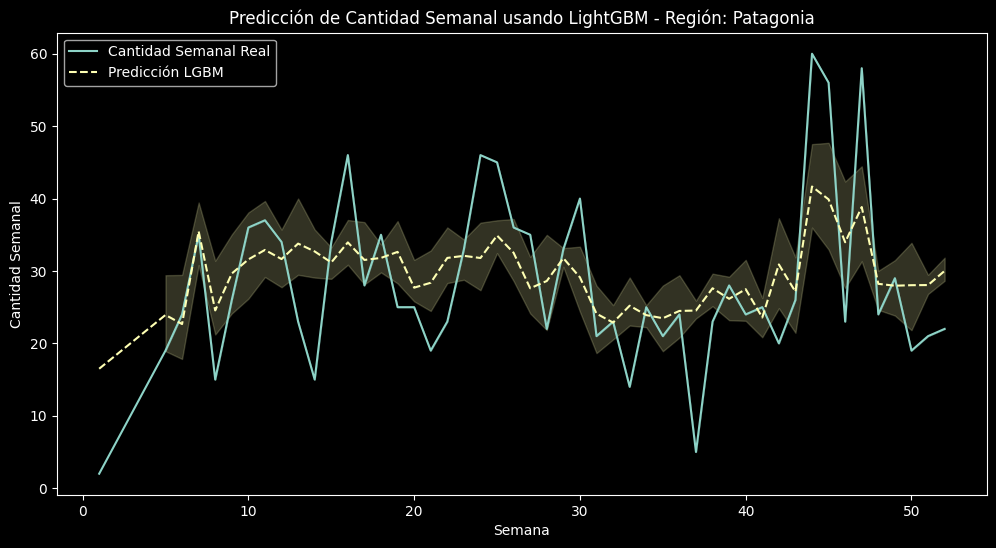

In [28]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df.dropna(subset=['Pred_LGBM']), x='semana', y='Cantidad_Semanal', errorbar=("ci", 95), label='Cantidad Semanal Real')
sns.lineplot(data=df.dropna(subset=['Pred_LGBM']), x='semana', y='Pred_LGBM', errorbar=("ci", 95), label='Predicción LGBM', linestyle='--')
plt.title('Predicción de Cantidad Semanal usando LightGBM')
plt.xlabel('Semana')
plt.ylabel('Cantidad Semanal')
plt.legend()
plt.show()

# Plots por región
for region in df['Region'].unique():
    plt.figure(figsize=(12, 6))
    region_data = df[df['Region'] == region].dropna(subset=['Pred_LGBM'])
    sns.lineplot(data=region_data, x='semana', y='Cantidad_Semanal', errorbar=("ci", 100), label='Cantidad Semanal Real')
    sns.lineplot(data=region_data, x='semana', y='Pred_LGBM', errorbar=("ci", 100), label='Predicción LGBM', linestyle='--')
    plt.title(f'Predicción de Cantidad Semanal usando LightGBM - Región: {region}')
    plt.xlabel('Semana')
    plt.ylabel('Cantidad Semanal')
    plt.legend()
    plt.show()

In [29]:
# Comparación de modelos
for result in [baseline_results_df, lasso_results_df, lgbm_results_df]:
    model_name = result['Model'].iloc[0]
    print(f"\nModelo: {model_name}")
    print(f"  Mean RMSE: {result.RMSE.mean():.2f}")
    print(f"  Mean MAE: {result.MAE.mean():.2f}")
    if 'R2' in result.columns:
        print(f"  Mean R2: {result.R2.mean():.2f}")
    print(f"  Mean Max_error: {result['Max_error'].mean():.2f}")


print(f"\nCantidad semanal promedio {np.mean(df.Cantidad_Semanal):.2f}")


Modelo: Baseline_MA
  Mean RMSE: 12.36
  Mean MAE: 8.13
  Mean Max_error: 55.00

Modelo: Lasso
  Mean RMSE: 16.59
  Mean MAE: 13.06
  Mean R2: 0.19
  Mean Max_error: 53.43

Modelo: LightGBM
  Mean RMSE: 11.45
  Mean MAE: 8.96
  Mean Max_error: 36.79

Cantidad semanal promedio 37.64


### Conclusión Evaluación Semanal

Observamos que LGBM es el modelo con menor RMSE, mientras que Moving Average tiene el menor MAE, sin embargo, el error máximo es mucho menor en LGBM, lo que indica que es el más preciso para predecir la demanda semanal en este conjunto de datos. 

Notamos que cantidad va de 1 a 100, con media 37.64, nuestro MAE es un porcentaje relativamente pequeño de esta media. Este modelo puede ayudar a optimizar inventarios y mejorar la planificación logística. 

Notamos además que el modelo baseline tiene un MAE mayor al LGBM, lo que indica que el modelo LGBM mejora significativamente la precisión de las predicciones en comparación con un enfoque simple de media móvil.

## Evaluación del Mejor Modelo (LGBM) por Día
A continuación, evaluamos el modelo LGBM a nivel diario para un análisis más granular.

LGBM - Evaluación diaria
            Model      RMSE       MAE  Max_error
0  LightGBM_Daily  5.979381  4.510214  25.027542
1  LightGBM_Daily  5.129886  4.133248  17.229083
2  LightGBM_Daily  4.684083  3.773108  16.538097
3  LightGBM_Daily  5.648599  4.454198  23.691702
4  LightGBM_Daily  5.682272  4.188988  26.125354

Mean RMSE: 5.42
Mean MAE: 4.21
Mean Max_error: 21.72
Cantidad diaria promedio: 8.47


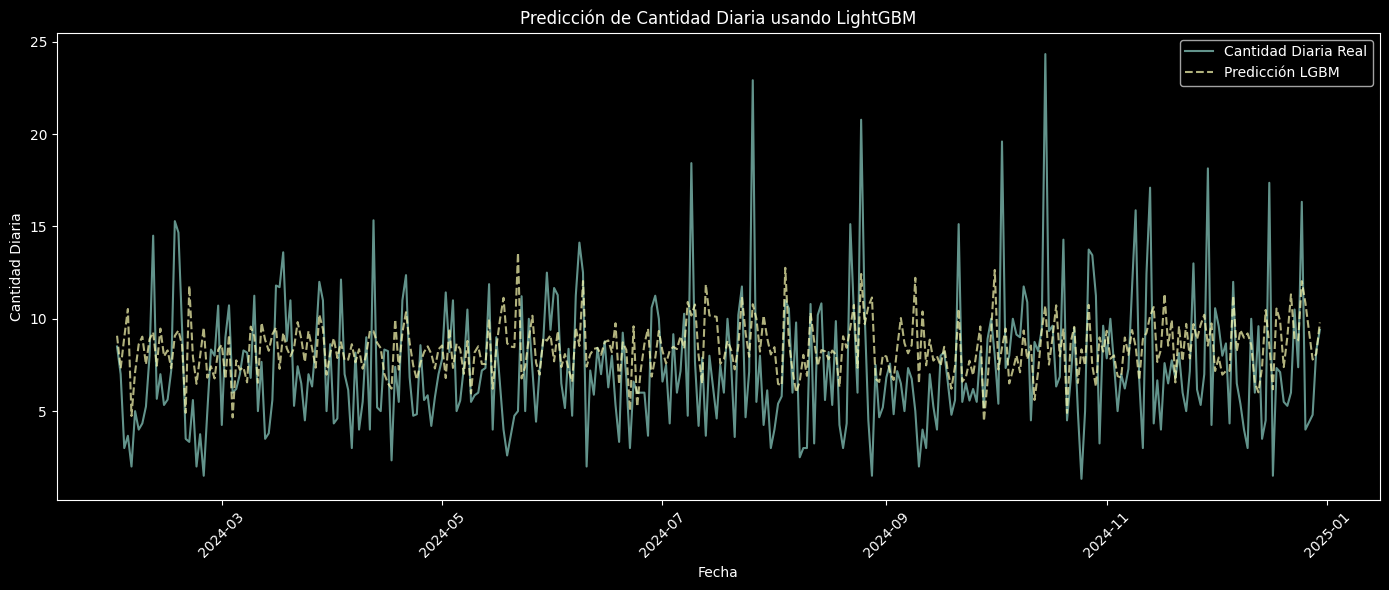

In [30]:
# LGBM - Evaluación por dia

df['Cantidad_Diaria'] = df.groupby(['Region', 'Fecha'])['Cantidad'].transform('sum')

X_daily = df_numeric.drop(columns=['Cantidad', 'Cantidad_Semanal', 'Monto_Venta'])
y_daily = df['Cantidad_Diaria']

# Eliminar NaNs
X_daily = X_daily.ffill().dropna()
y_daily = y_daily.loc[X_daily.index]

# Time Series Split
tscv_daily = TimeSeriesSplit(n_splits=5)

results_daily = []
df['Pred_LGBM_Daily'] = np.nan

for train_index, test_index in tscv_daily.split(X_daily):
    X_train, X_test = X_daily.iloc[train_index], X_daily.iloc[test_index]
    y_train, y_test = y_daily.iloc[train_index], y_daily.iloc[test_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbose': -1
    }

    gbm_daily = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=lgb_eval)
    
    y_pred_daily = gbm_daily.predict(X_test, num_iteration=gbm_daily.best_iteration)
    df.loc[X_daily.index[test_index], 'Pred_LGBM_Daily'] = y_pred_daily

    rmse = np.sqrt(mean_squared_error(y_test, y_pred_daily))
    mae = mean_absolute_error(y_test, y_pred_daily)
    max_err = np.max(np.abs(y_test - y_pred_daily))

    results_daily.append({
        'Model': 'LightGBM_Daily',
        'RMSE': rmse,
        'MAE': mae,
        'Max_error': max_err
    })

lgbm_daily_results_df = pd.DataFrame(results_daily)
print("LGBM - Evaluación diaria")
print(lgbm_daily_results_df)
print(f"\nMean RMSE: {lgbm_daily_results_df.RMSE.mean():.2f}")
print(f"Mean MAE: {lgbm_daily_results_df.MAE.mean():.2f}")
print(f"Mean Max_error: {lgbm_daily_results_df.Max_error.mean():.2f}")

print(f"Cantidad diaria promedio: {np.mean(df.Cantidad_Diaria):.2f}")

# Visualización LGBM por dia - Global
df_daily_plot = df.dropna(subset=['Pred_LGBM_Daily']).copy()
df_daily_plot = df_daily_plot.sort_values('Fecha')

plt.figure(figsize=(14, 6))
daily_agg = df_daily_plot.groupby('Fecha').agg({'Cantidad_Diaria': 'mean', 'Pred_LGBM_Daily': 'mean'}).reset_index()
plt.plot(daily_agg['Fecha'], daily_agg['Cantidad_Diaria'], label='Cantidad Diaria Real', alpha=0.7)
plt.plot(daily_agg['Fecha'], daily_agg['Pred_LGBM_Daily'], label='Predicción LGBM', linestyle='--', alpha=0.7)
plt.title('Predicción de Cantidad Diaria usando LightGBM')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Diaria')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Evaluación de Modelos por Región
Analizamos el rendimiento de cada modelo en cada región para identificar si algún modelo funciona mejor en regiones específicas.

In [31]:
# Evaluación de modelos por cada region
region_model_results = []

for region in df.Region.unique():
    region_df = df[df['Region'] == region].copy()
    
    # Baseline - Media Móvil
    ma_data = region_df.dropna(subset=['Pred_MA', 'Cantidad_Semanal'])
    if len(ma_data) > 0:
        rmse_ma = np.sqrt(mean_squared_error(ma_data['Cantidad_Semanal'], ma_data['Pred_MA']))
        mae_ma = mean_absolute_error(ma_data['Cantidad_Semanal'], ma_data['Pred_MA'])
        max_err_ma = np.max(np.abs(ma_data['Cantidad_Semanal'] - ma_data['Pred_MA']))
        region_model_results.append({
            'Region': region,
            'Model': 'Baseline_MA',
            'RMSE': rmse_ma,
            'MAE': mae_ma,
            'Max_error': max_err_ma,
            'N_samples': len(ma_data)
        })
    
    # Lasso
    lasso_data = region_df.dropna(subset=['Pred_Lasso', 'Cantidad_Semanal'])
    if len(lasso_data) > 0:
        rmse_lasso = np.sqrt(mean_squared_error(lasso_data['Cantidad_Semanal'], lasso_data['Pred_Lasso']))
        mae_lasso = mean_absolute_error(lasso_data['Cantidad_Semanal'], lasso_data['Pred_Lasso'])
        max_err_lasso = np.max(np.abs(lasso_data['Cantidad_Semanal'] - lasso_data['Pred_Lasso']))
        region_model_results.append({
            'Region': region,
            'Model': 'Lasso',
            'RMSE': rmse_lasso,
            'MAE': mae_lasso,
            'Max_error': max_err_lasso,
            'N_samples': len(lasso_data)
        })
    
    # LightGBM
    lgbm_data = region_df.dropna(subset=['Pred_LGBM', 'Cantidad_Semanal'])
    if len(lgbm_data) > 0:
        rmse_lgbm = np.sqrt(mean_squared_error(lgbm_data['Cantidad_Semanal'], lgbm_data['Pred_LGBM']))
        mae_lgbm = mean_absolute_error(lgbm_data['Cantidad_Semanal'], lgbm_data['Pred_LGBM'])
        max_err_lgbm = np.max(np.abs(lgbm_data['Cantidad_Semanal'] - lgbm_data['Pred_LGBM']))
        region_model_results.append({
            'Region': region,
            'Model': 'LightGBM',
            'RMSE': rmse_lgbm,
            'MAE': mae_lgbm,
            'Max_error': max_err_lgbm,
            'N_samples': len(lgbm_data)
        })

region_model_df = pd.DataFrame(region_model_results)
print("Evaluación de modelos por región")
display(region_model_df)

print("Mejor modelo por región:")
best_models = region_model_df.loc[region_model_df.groupby('Region')['RMSE'].idxmin()]
display(best_models)

Evaluación de modelos por región


,Region,Model,RMSE,MAE,Max_error,N_samples
0,Buenos Aires,Baseline_MA,15.884135,10.106592,55.000000,713
1,Buenos Aires,Lasso,19.654004,15.603583,54.857537,539
2,Buenos Aires,LightGBM,14.378603,11.239927,45.315103,574
3,Centro,Baseline_MA,9.619486,6.882567,33.000000,413
4,Centro,Lasso,14.106681,11.588255,38.172731,353
5,Centro,LightGBM,8.997678,7.074120,30.818684,353
6,Cuyo,Baseline_MA,11.518988,8.210784,39.000000,306
7,Cuyo,Lasso,14.604145,12.010550,35.123654,254
8,Cuyo,LightGBM,10.369544,8.320678,30.591543,254
9,NEA,Baseline_MA,9.666537,7.234252,28.000000,254


Mejor modelo por región:


,Region,Model,RMSE,MAE,Max_error,N_samples
2,Buenos Aires,LightGBM,14.378603,11.239927,45.315103,574
5,Centro,LightGBM,8.997678,7.074120,30.818684,353
8,Cuyo,LightGBM,10.369544,8.320678,30.591543,254
9,NEA,Baseline_MA,9.666537,7.234252,28.000000,254
12,NOA,Baseline_MA,5.925676,4.659091,13.500000,44
17,Patagonia,LightGBM,10.299473,7.826050,30.588075,348


In [32]:
# Cuantos datos hay por region?
region_counts = df['Region'].value_counts().reset_index()
region_counts.columns = ['Region', 'Count']
print("Cantidad de datos por región:")
display(region_counts)

Cantidad de datos por región:


,Region,Count
0,Buenos Aires,714
1,Centro,414
2,Patagonia,404
3,Cuyo,307
4,NEA,255
5,NOA,45


Podemos observar que LGBM es el mejor modelo en 4 de 6 regiones. En NEA y NOA, el modelo de Moving Average es mejor que LGBM. Notamos que estas son las regiones con menos datos, por lo que el modelo más simple puede generalizar mejor en estos casos.

## Métricas Detalladas por Modelo
Resumen completo de métricas incluyendo error máximo, error promedio por región, errores globales, y otras estadísticas relevantes.

In [33]:
# Calcular métricas detalladas para cada modelo
def calculate_detailed_metrics(df, y_col, pred_col, model_name):
    """Calcula métricas detalladas para un modelo."""
    data = df.dropna(subset=[pred_col, y_col]).copy()
    
    if len(data) == 0:
        return None
    
    errors = data[y_col] - data[pred_col]
    abs_errors = np.abs(errors)
    
    # Métricas globales
    metrics = {
        'Modelo': model_name,
        'RMSE_Global': np.sqrt(mean_squared_error(data[y_col], data[pred_col])),
        'MAE_Global': mean_absolute_error(data[y_col], data[pred_col]),
        'Max_Error_Global': abs_errors.max(),
        'Min_Error_Global': abs_errors.min(),
        'Median_Error_Global': abs_errors.median(),
        'Std_Error_Global': abs_errors.std(),
        'Error_Percentil_95': np.percentile(abs_errors, 95),
        'Error_Percentil_99': np.percentile(abs_errors, 99),
        'N_Predicciones': len(data)
    }
    
    # Error promedio por región
    for region in data['Region'].unique():
        region_data = data[data['Region'] == region]
        if len(region_data) > 0:
            region_errors = np.abs(region_data[y_col] - region_data[pred_col])
            metrics[f'MAE_{region}'] = region_errors.mean()
            metrics[f'Max_Error_{region}'] = region_errors.max()
    
    return metrics

# Calcular métricas para cada modelo
all_metrics = []

# Baseline MA
ma_metrics = calculate_detailed_metrics(df, 'Cantidad_Semanal', 'Pred_MA', 'Baseline_MA')
if ma_metrics:
    all_metrics.append(ma_metrics)

# LightGBM
lgbm_metrics = calculate_detailed_metrics(df, 'Cantidad_Semanal', 'Pred_LGBM', 'LightGBM')
if lgbm_metrics:
    all_metrics.append(lgbm_metrics)

metrics_df = pd.DataFrame(all_metrics)

# Mostrar métricas globales
print("Metricas globales por modelo")
global_cols = ['Modelo', 'RMSE_Global', 'MAE_Global', 'Max_Error_Global', 'Min_Error_Global', 
               'Median_Error_Global', 'Std_Error_Global', 'Error_Percentil_95', 'Error_Percentil_99', 'N_Predicciones']
display(metrics_df[global_cols].round(2))

Metricas globales por modelo


,Modelo,RMSE_Global,MAE_Global,Max_Error_Global,Min_Error_Global,Median_Error_Global,Std_Error_Global,Error_Percentil_95,Error_Percentil_99,N_Predicciones
0,Baseline_MA,12.44,8.19,55.00,0.0,5.50,9.37,26.20,44.00,2133
1,LightGBM,11.60,8.96,45.32,0.0,7.09,7.37,23.53,31.58,1780


In [35]:
# Save csv of df
df = df.drop(columns=["Pred_MA", "Pred_Lasso", "Pred_LGBM", "Pred_LGBM_Daily", "Cantidad_Diaria"])
df.to_csv('../data_clean/data_modelado.csv', index=False)